## Final Project Submission

Please fill out:
* Student name: Sabatino Chen
* Student pace: full time
* Scheduled project review date/time: 5/17/2019 2PM EST
* Instructor name: Joe San Pietro
* Blog post URL: https://medium.com/@sabatinochen/deep-learning-b04a42c5a341


# Intro

[LendingClub](https://www.lendingclub.com/) is a peer-to-peer lending company as explained by [Wikipedia](https://en.wikipedia.org/wiki/LendingClub): 

"LendingClub enables borrowers to create unsecured personal loans between \\$1,000 and $40,000. The standard loan period is three years. Investors can search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. LendingClub makes money by charging borrowers an origination fee and investors a service fee."

For this project I will be making a Deep Neural Network that will classify whether a loan will be "Charged Off" or "Fully paid". This can be useful for investors determining which loans or loan portfolios they would like to invest in on the LendingClub platform. I will be using a dataset from LendingClub that has records of loans accepted from 2007 to the third quarter of 2017.

Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
 

# Obtain Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df = pd.read_csv('accepted_2007_to_2017Q3.csv', low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-2014,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,0.0,Aug-1994,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,w,0.00,0.00,17392.37,...,196500.0,149140.0,10000.0,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-2014,Charged Off,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,0.0,Sep-1989,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,w,0.00,0.00,6611.69,...,179407.0,15030.0,13000.0,11325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,Programming Analysis Supervisor,6 years,RENT,63800.0,Source Verified,Dec-2014,Fully Paid,n,NaN,credit_card,Credit card refinancing,658xx,MO,18.49,0.0,Aug-2003,685.0,689.0,0.0,60.0,NaN,10.0,0.0,16374.0,76.2,35.0,w,0.00,0.00,25512.20,...,57073.0,42315.0,15000.0,35573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,Senior Sales Professional,10+ years,MORTGAGE,125000.0,Verified,Dec-2014,Current,n,NaN,car,Car financing,953xx,CA,8.31,1.0,Oct-2000,665.0,669.0,0.0,17.0,NaN,8.0,0.0,5753.0,100.9,13.0,w,6673.54,6673.54,11207.67,...,368700.0,18007.0,4400.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,Technical Specialist,< 1 year,RENT,50000.0,Source Verified,Dec-2014,Charged Off,n,NaN,debt_consolidation,Debt consolidation,850xx,AZ,34.81,0.0,Aug-2002,685.0,689.0,1.0,NaN,NaN,11.0,0.0,16822.0,91.9,20.0,f,0.00,0.00,2281.98,...,82331.0,64426.0,4900.0,64031.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


Notice how there are 1,646,801 loans with 150 features.

# Scrub Data

The target value we will be classifying is `loan_status`, let's take a look at this column.

In [4]:
df.loan_status.value_counts(normalize=True)

Current                                                0.479087
Fully Paid                                             0.392829
Charged Off                                            0.102068
Late (31-120 days)                                     0.014430
In Grace Period                                        0.006360
Late (16-30 days)                                      0.003514
Does not meet the credit policy. Status:Fully Paid     0.001207
Does not meet the credit policy. Status:Charged Off    0.000462
Default                                                0.000043
Name: loan_status, dtype: float64

Since we are predicting whether the loan was fully paid or charged off, we will not be using current loans to build the DNN.  Also the other labels listed above that make up 1% or less of the dataset won't be used since they are rare occurences.

In [5]:
# Drop rows not in 'Fully Paid' or 'Charged Off'
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off', 
                                    'Does not meet the credit policy. Status:Fully Paid', 
                                    'Does not meet the credit policy. Status:Charged Off'])]
df.shape

(817735, 150)

In [6]:
# Combine other labels into fully paid or charged off
df.loan_status.replace(to_replace='Does not meet the credit policy. Status:Fully Paid', 
                       value= 'Fully Paid', inplace=True)
df.loan_status.replace(to_replace='Does not meet the credit policy. Status:Charged Off', 
                       value= 'Charged Off', inplace=True)

In [7]:
df.loan_status.value_counts(normalize=True)

Fully Paid     0.793521
Charged Off    0.206479
Name: loan_status, dtype: float64

Notice how we are dealing with a bit of an unbalanced dataset, we will probably have to do something about this later in order to get good results.

Now lets start checking for null values

In [8]:
# Finding the the count and percentage of values that are missing in the dataframe.
df_null = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})

# printing columns with null count more than 0
df_null[df_null['Count'] > 0] 

,Count,Percent
member_id,817735,100.000000
emp_title,48730,5.959143
emp_length,42287,5.171235
annual_inc,4,0.000489
desc,695580,85.061787
title,7920,0.968529
dti,36,0.004402
delinq_2yrs,29,0.003546
earliest_cr_line,29,0.003546
inq_last_6mths,30,0.003669


Here we can see that there are many columns with null values, and many with over 80%! Since it will be hard to make any use of these columns we will remove any missing at least 30%. This will also help reduce how many features we are dealing with.

In [9]:
# Remove columns missing 30% of data
df1 = df.dropna(axis=1, thresh=int(0.70*len(df)))

In [10]:
df1.shape

(817735, 92)

Now to the best of my ability, I will go through LendingClub's explanations of all the features and remove any that seem unncessary or not readily available for investors since this model will be used to try and predict which types of loans to invest in on the LendingClub platform or based on the availble information. Below are images of what it looks like to use the LendingClub platform in order to decide on loans you want to invest in.  

With the lack of resources of being able to discuss important features with someone with more domain expertise than myself my methodology was to use this information below along with the descriptions from the Data Dictionary to determine which features to keep going forward.

<img src='Screen Shot 2019-05-10 at 11.00.51 AM.png'>

<img src='Screen Shot 2019-05-10 at 11.02.40 AM.png' height=40%>


<img src='Screen Shot 2019-05-11 at 8.01.51 PM.png' height=40%>

In [11]:
# Here is our list of remaining features so far
print(sorted(df1.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

In [2]:
# Reading in feature explanations from LC's Data Dictionary
df_description = pd.read_excel('LCDataDictionary.xlsx').dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [15]:
# Features being kept after going through LC Data Dictionary
keep_list = ['acc_now_delinq', 'addr_state', 'annual_inc', 'application_type', 'collections_12_mths_ex_med', 
             'delinq_2yrs', 'delinq_amnt', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 
             'fico_range_low', 'funded_amnt', 'grade', 'home_ownership','inq_last_6mths', 'installment', 'int_rate', 
             'issue_d', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 
             'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status']

In [16]:
# Remaining features to be dropped after intial feature analysis
drop_list = [col for col in df1.columns if col not in keep_list]
print(drop_list)

['id', 'funded_amnt_inv', 'pymnt_plan', 'zip_code', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'policy_code', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'to

In [17]:
df2 = df1.drop(labels=drop_list, axis=1)
df2.shape

(817735, 33)

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817735 entries, 0 to 1646792
Data columns (total 33 columns):
loan_amnt                     817735 non-null float64
funded_amnt                   817735 non-null float64
term                          817735 non-null object
int_rate                      817735 non-null float64
installment                   817735 non-null float64
grade                         817735 non-null object
sub_grade                     817735 non-null object
emp_title                     769005 non-null object
emp_length                    775448 non-null object
home_ownership                817735 non-null object
annual_inc                    817731 non-null float64
verification_status           817735 non-null object
issue_d                       817735 non-null object
loan_status                   817735 non-null object
purpose                       817735 non-null object
title                         809815 non-null object
addr_state                    81773

In [19]:
# Delete original df, df1, and df_null for memory
del df
del df_null

In [20]:
# Create new csv so don't have to load large dataset every time
# Commented out so doesn't run every time
# df2.to_csv('loans_smaller.csv')

In [3]:
df2 = pd.read_csv('loans_smaller.csv', low_memory=False)
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies
0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,...,6.0,0.0,138008.0,29.0,17.0,0.0,Individual,0.0,0.0,0.0
1,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,...,17.0,0.0,6133.0,31.6,36.0,0.0,Individual,0.0,0.0,0.0
2,21425.0,21425.0,60 months,15.59,516.36,D,D1,Programming Analysis Supervisor,6 years,RENT,...,10.0,0.0,16374.0,76.2,35.0,0.0,Individual,0.0,0.0,0.0
3,7650.0,7650.0,36 months,13.66,260.20,C,C3,Technical Specialist,< 1 year,RENT,...,11.0,0.0,16822.0,91.9,20.0,0.0,Individual,0.0,0.0,0.0
4,9600.0,9600.0,36 months,13.66,326.53,C,C3,Admin Specialist,10+ years,RENT,...,12.0,0.0,16388.0,59.4,44.0,0.0,Individual,0.0,0.0,0.0


## Categorical Cleaning
For further cleaning I will examine the categorcial data

In [24]:
df2.columns.groupby(df2.dtypes)

{dtype('float64'): Index(['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc',
        'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
        'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
        'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq',
        'delinq_amnt', 'pub_rec_bankruptcies'],
       dtype='object'),
 dtype('O'): Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'verification_status', 'issue_d', 'loan_status',
        'purpose', 'title', 'addr_state', 'earliest_cr_line',
        'application_type'],
       dtype='object')}

In [25]:
categorical_df = df2[['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'verification_status', 'issue_d', 'loan_status',
        'purpose', 'title', 'addr_state', 'earliest_cr_line',
        'application_type']]
categorical_df.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,addr_state,earliest_cr_line,application_type
0,60 months,C,C1,MANAGEMENT,10+ years,RENT,Source Verified,Dec-2014,Fully Paid,debt_consolidation,Debt consolidation,VA,Aug-1994,Individual
1,36 months,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,Not Verified,Dec-2014,Charged Off,credit_card,Credit card refinancing,CA,Sep-1989,Individual
2,60 months,D,D1,Programming Analysis Supervisor,6 years,RENT,Source Verified,Dec-2014,Fully Paid,credit_card,Credit card refinancing,MO,Aug-2003,Individual
4,36 months,C,C3,Technical Specialist,< 1 year,RENT,Source Verified,Dec-2014,Charged Off,debt_consolidation,Debt consolidation,AZ,Aug-2002,Individual
5,36 months,C,C3,Admin Specialist,10+ years,RENT,Source Verified,Dec-2014,Fully Paid,debt_consolidation,Debt consolidation,NJ,Nov-1992,Individual


In [26]:
categorical_df.isna().sum()/len(categorical_df)

term                   0.000000
grade                  0.000000
sub_grade              0.000000
emp_title              0.059591
emp_length             0.051712
home_ownership         0.000000
verification_status    0.000000
issue_d                0.000000
loan_status            0.000000
purpose                0.000000
title                  0.009685
addr_state             0.000000
earliest_cr_line       0.000035
application_type       0.000000
dtype: float64

### term

In [27]:
df2.term.value_counts()

 36 months    620898
 60 months    196837
Name: term, dtype: int64

In [28]:
# Will make term values into integers
df2.term = df2.term.apply(lambda x: int(x[:3]))
df2.term.value_counts()

36    620898
60    196837
Name: term, dtype: int64

### grade and sub_grade

In [29]:
# grade and sub_grade seem to be related
print('grade:', df2.grade.unique())
print('sub grade:', df2.sub_grade.unique())

grade: ['C' 'A' 'D' 'B' 'E' 'F' 'G']
sub grade: ['C1' 'A3' 'D1' 'C3' 'B5' 'B4' 'C4' 'D5' 'B3' 'C5' 'D2' 'C2' 'B2' 'A4'
 'D3' 'B1' 'A5' 'E5' 'F1' 'E4' 'D4' 'E2' 'E1' 'G2' 'G1' 'F3' 'F2' 'A1'
 'A2' 'G3' 'E3' 'F4' 'G4' 'F5' 'G5']


In [30]:
# Will drop grade since it is shown in sub_grade
df2.drop('grade', axis=1, inplace=True)

### emp_title

In [31]:
# emp_title seems to have some nulls and a lot of values in general
# This would cause high dimensionality after getting dummy variables
df2.emp_title.nunique()

281983

In [32]:
# With that many different types of titles, will just drop the column
df2.drop('emp_title', axis=1, inplace=True)

### emp_length

In [33]:
df2.emp_length.value_counts(dropna=False)

10+ years    265343
2 years       73842
3 years       65265
< 1 year      65044
1 year        53759
5 years       52321
4 years       48957
NaN           42287
6 years       40434
7 years       39507
8 years       38994
9 years       31982
Name: emp_length, dtype: int64

In [34]:
# Will convert these to numerical data and make the NaN values equal to 0 and < 1 equal to 0.5
df2.emp_length.replace(to_replace='10+ years', value='10 years', inplace=True)
df2.emp_length.replace(to_replace='< 1 year', value='15 years', inplace=True)
df2.emp_length.fillna('0 years', inplace=True)

In [35]:
# marked < 1 year as 15 years so can change to 0.5
df2['emp_length'] = df2['emp_length'].str.extract('(\d+)').astype(float)
df2.emp_length.replace(to_replace=15.0, value=0.5, inplace=True)
df2.emp_length.value_counts(dropna=False)

10.0    265343
2.0      73842
3.0      65265
0.5      65044
1.0      53759
5.0      52321
4.0      48957
0.0      42287
6.0      40434
7.0      39507
8.0      38994
9.0      31982
Name: emp_length, dtype: int64

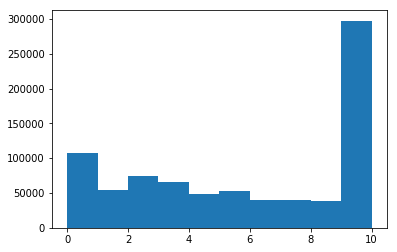

In [36]:
plt.hist(df2['emp_length'])
plt.show()

### home_ownership

In [37]:
df2.home_ownership.value_counts(dropna=False)

MORTGAGE    408122
RENT        326334
OWN          82952
OTHER          182
ANY             94
NONE            51
Name: home_ownership, dtype: int64

In [38]:
# Since above in the Data Dictionary they only use MORTGAGE, RENT, OWN, and OTHER, will combine ANY and NONE with OTHER
df2.home_ownership.replace(['ANY', 'NONE'], 'OTHER', inplace=True)
df2.home_ownership.value_counts(dropna=False)

MORTGAGE    408122
RENT        326334
OWN          82952
OTHER          327
Name: home_ownership, dtype: int64

### issue_d

In [39]:
df2.issue_d.value_counts()

Oct-2014    33699
Jul-2014    25974
Jul-2015    23990
Mar-2016    22914
Jan-2015    22750
Oct-2015    22431
Nov-2014    21186
Apr-2015    20097
Dec-2015    19106
May-2015    17964
Aug-2015    17492
Apr-2014    17140
May-2014    17133
Aug-2014    16780
Nov-2015    16540
Feb-2016    15385
Jun-2015    15304
Jun-2014    15207
Mar-2015    14997
Mar-2014    14988
Feb-2015    14464
Jan-2014    14464
Feb-2014    13945
Dec-2013    13941
Sep-2015    13838
Nov-2013    13739
Jan-2016    13300
Oct-2013    13043
Apr-2016    12492
Sep-2013    12077
            ...  
Dec-2009      658
Oct-2009      604
Sep-2009      507
Aug-2009      446
Jul-2009      411
Jun-2009      406
Mar-2008      402
May-2009      359
Apr-2009      333
Mar-2009      324
Feb-2008      306
Jan-2008      305
Feb-2009      302
Jan-2009      269
Apr-2008      259
Dec-2008      253
Nov-2008      209
Dec-2007      172
Jul-2008      141
Jun-2008      124
Oct-2008      122
May-2008      115
Nov-2007      112
Oct-2007      105
Aug-2008  

In [40]:
df2.issue_d = df2.issue_d.apply(lambda x: int(x[-4:]))
df2.issue_d.head()

0    2014
1    2014
2    2014
4    2014
5    2014
Name: issue_d, dtype: int64

### title

In [41]:
df2.title.nunique()

61769

In [42]:
# With this many different titles we will drop this feature, also has some null values
df2.drop('title', axis=1, inplace=True)

### earliest_cr_line

In [43]:
df2.earliest_cr_line.value_counts()

Aug-2001    6035
Aug-2000    5846
Oct-2000    5693
Oct-2001    5673
Aug-2002    5603
Sep-2002    5455
Sep-2003    5351
Oct-2002    5322
Nov-1999    5320
Sep-2000    5303
Nov-2000    5302
Oct-1999    5274
Sep-2001    5142
Aug-2003    5067
Oct-2003    5050
Aug-1999    5013
Sep-1999    5013
Sep-2004    4987
Nov-2001    4803
Jul-2001    4740
Dec-2001    4709
Dec-2000    4697
Jul-2003    4649
Dec-1999    4646
Aug-2004    4633
Mar-2001    4627
May-2001    4618
Jul-2000    4570
Sep-1998    4561
Jun-2001    4528
            ... 
Sep-1953       1
Nov-1953       1
May-1957       1
Jul-1951       1
Nov-1950       1
Oct-1957       1
Dec-1950       1
Feb-1961       1
Apr-1960       1
Sep-1960       1
Jan-1948       1
Jan-1946       1
Mar-1955       1
Nov-1956       1
Feb-1957       1
Jun-1949       1
Dec-1956       1
Oct-1954       1
Sep-1956       1
Nov-1957       1
Feb-1962       1
Jun-1955       1
Feb-1960       1
Nov-1955       1
Sep-1957       1
Jul-1955       1
May-1953       1
Aug-1950      

In [44]:
# With this wide range of dates, will just take the years and convert into integers
# Will also drop very small amount of data with null values.
df2.earliest_cr_line.dropna(inplace=True)
df2.earliest_cr_line = df2.earliest_cr_line.apply(lambda x: int(x[-4:]))
df2.earliest_cr_line.head()

0    1994.0
1    1989.0
2    2003.0
4    2002.0
5    1992.0
Name: earliest_cr_line, dtype: float64

In [45]:
df2.columns.groupby(df2.dtypes)

{dtype('int64'): Index(['term', 'issue_d'], dtype='object'),
 dtype('float64'): Index(['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'emp_length',
        'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line',
        'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
        'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
        'collections_12_mths_ex_med', 'acc_now_delinq', 'delinq_amnt',
        'pub_rec_bankruptcies'],
       dtype='object'),
 dtype('O'): Index(['sub_grade', 'home_ownership', 'verification_status', 'loan_status',
        'purpose', 'addr_state', 'application_type'],
       dtype='object')}

In [46]:
categorical_df = df2[['sub_grade', 'home_ownership', 'verification_status', 'loan_status',
        'purpose', 'addr_state', 'application_type']]

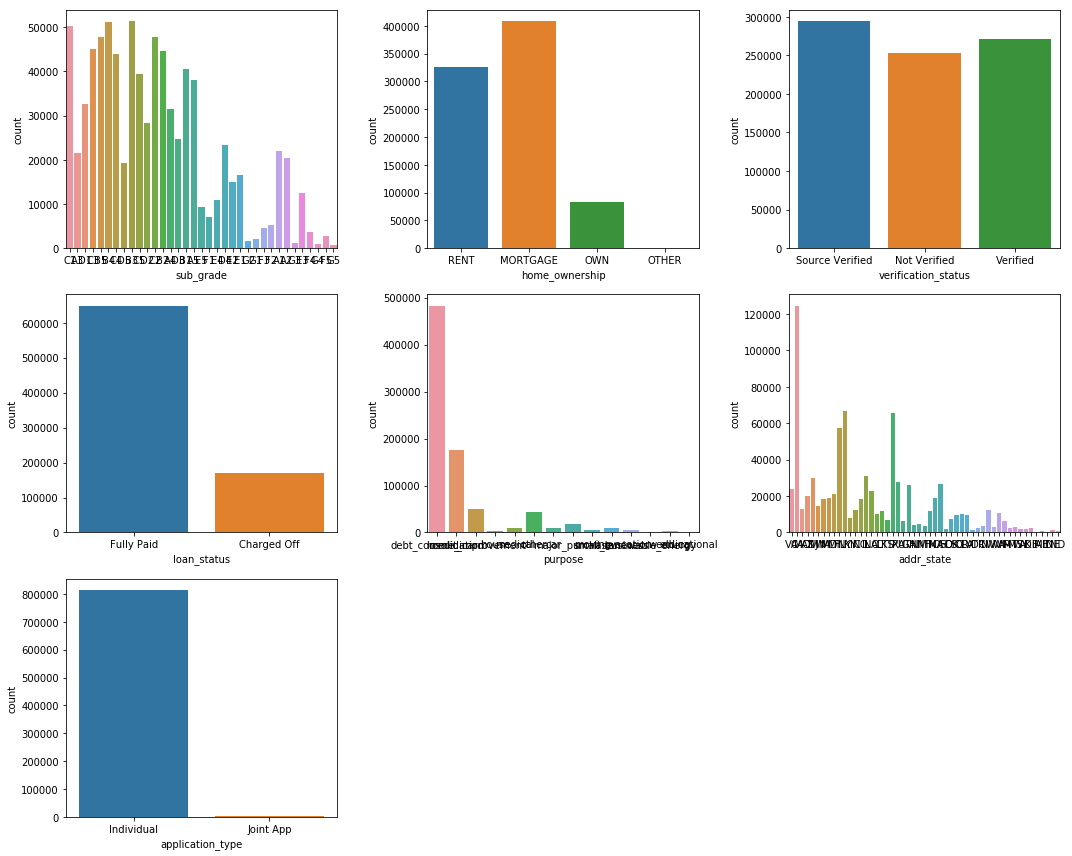

In [47]:
fig = plt.figure(figsize=(15,12))
ax1 = plt.subplot(331)
sns.countplot(categorical_df['sub_grade'])
ax2 = plt.subplot(332)
sns.countplot(categorical_df['home_ownership'])
ax3 = plt.subplot(333)
sns.countplot(categorical_df['verification_status'])
ax4 = plt.subplot(334)
sns.countplot(categorical_df['loan_status'])
ax5 = plt.subplot(335)
sns.countplot(categorical_df['purpose'])
ax6 = plt.subplot(336)
sns.countplot(categorical_df['addr_state'])
ax7 = plt.subplot(337)
sns.countplot(categorical_df['application_type'])
plt.tight_layout()
plt.show()

## Numerical Cleaning

In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817735 entries, 0 to 1646792
Data columns (total 30 columns):
loan_amnt                     817735 non-null float64
funded_amnt                   817735 non-null float64
term                          817735 non-null int64
int_rate                      817735 non-null float64
installment                   817735 non-null float64
sub_grade                     817735 non-null object
emp_length                    817735 non-null float64
home_ownership                817735 non-null object
annual_inc                    817731 non-null float64
verification_status           817735 non-null object
issue_d                       817735 non-null int64
loan_status                   817735 non-null object
purpose                       817735 non-null object
addr_state                    817735 non-null object
dti                           817699 non-null float64
delinq_2yrs                   817706 non-null float64
earliest_cr_line              8177

In [49]:
# Check for nulls in numerical data
df2.isna().sum()/len(df2)

loan_amnt                     0.000000
funded_amnt                   0.000000
term                          0.000000
int_rate                      0.000000
installment                   0.000000
sub_grade                     0.000000
emp_length                    0.000000
home_ownership                0.000000
annual_inc                    0.000005
verification_status           0.000000
issue_d                       0.000000
loan_status                   0.000000
purpose                       0.000000
addr_state                    0.000000
dti                           0.000044
delinq_2yrs                   0.000035
earliest_cr_line              0.000035
fico_range_low                0.000000
fico_range_high               0.000000
inq_last_6mths                0.000037
open_acc                      0.000035
pub_rec                       0.000035
revol_bal                     0.000000
revol_util                    0.000648
total_acc                     0.000035
collections_12_mths_ex_me

In [50]:
# Since very small amounts of data is missing, will just drop null values.
df2.dropna(inplace=True)

In [51]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,815830.0,14307.991340,8498.546480,500.00,8000.00,12000.00,20000.00,40000.00
funded_amnt,815830.0,14293.688943,8491.751363,500.00,8000.00,12000.00,20000.00,40000.00
term,815830.0,41.787529,10.266710,36.00,36.00,36.00,36.00,60.00
int_rate,815830.0,13.494582,4.615407,5.32,10.15,13.11,16.29,30.99
installment,815830.0,436.532324,255.704444,4.93,251.36,377.04,575.89,1714.54
emp_length,815830.0,5.701871,3.750376,0.00,2.00,6.00,10.00,10.00
annual_inc,815830.0,75226.495047,65203.641213,100.00,45000.00,65000.00,90000.00,9550000.00
issue_d,815830.0,2014.245712,1.533658,2007.00,2013.00,2014.00,2015.00,2017.00
dti,815830.0,17.867738,8.852701,-1.00,11.64,17.36,23.62,999.00
delinq_2yrs,815830.0,0.306351,0.855482,0.00,0.00,0.00,0.00,39.00


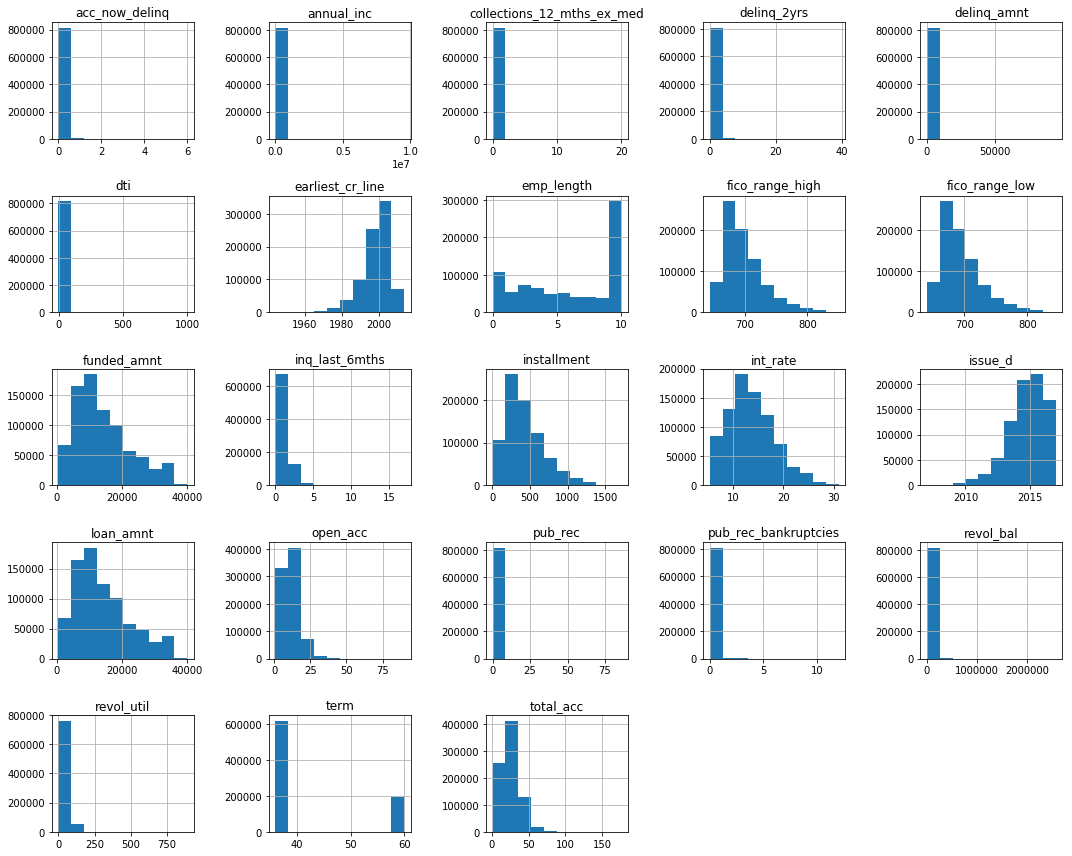

In [52]:
df2.hist(figsize=(15,12))
plt.tight_layout()
plt.show()

### Feature Selection
First will start off by dropping features that have majority of their values as 0 and the rest as very rare occurences.  These features won't help much for the model and cannot be log transformed.

In [53]:
drop_list2 = ['delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'collections_12_mths_ex_med',
             'acc_now_delinq', 'delinq_amnt', 'pub_rec_bankruptcies']

In [54]:
df2.drop(labels=drop_list2, axis=1, inplace=True)

### FICO Score
Since there is a high and low range for FICO score, I will take the average to create one feature out of the two.

In [55]:
df2['fico_score'] = 0.5*df2.fico_range_high + 0.5*df2.fico_range_low
df2.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

### DTI (debt to income ratio)
This feature seems to have some bad outliers, you shouldn't be able to have a debt to income ratio that is greater than 100 

In [56]:
len(df2[df2['dti']>100])

62

In [57]:
# Since this is a very small amount of the dataset, we can drop these rows.
df2.drop(df2[df2['dti']>100].index, inplace=True)

### Log Transform
The following features we will perform log transformation since their histograms show some extreme skewness

In [58]:
df2['annual_inc_log'] = np.log(df2.annual_inc)
df2['open_acc_log'] = np.log(df2.open_acc)
df2['total_acc_log'] = np.log(df2.total_acc)

In [59]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815768 entries, 0 to 1646792
Data columns (total 25 columns):
loan_amnt              815768 non-null float64
funded_amnt            815768 non-null float64
term                   815768 non-null int64
int_rate               815768 non-null float64
installment            815768 non-null float64
sub_grade              815768 non-null object
emp_length             815768 non-null float64
home_ownership         815768 non-null object
annual_inc             815768 non-null float64
verification_status    815768 non-null object
issue_d                815768 non-null int64
loan_status            815768 non-null object
purpose                815768 non-null object
addr_state             815768 non-null object
dti                    815768 non-null float64
earliest_cr_line       815768 non-null float64
open_acc               815768 non-null float64
revol_bal              815768 non-null float64
revol_util             815768 non-null float64
total

# EDA

First to start off, let's take a look at the distribution of loans funded. Majority of the loans issued are between \\$10,000 and \\$20,000 with the mean being about $14,000.

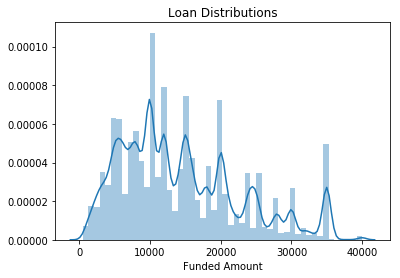

In [60]:
sns.distplot(df2.loan_amnt)
plt.title('Loan Distributions')
plt.xlabel('Funded Amount')
plt.show()

## Loans issued by year

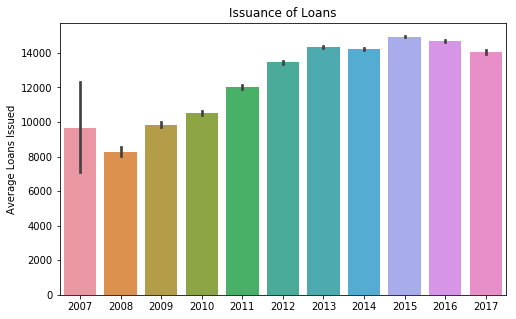

In [61]:
plt.figure(figsize=(8,5))
sns.barplot('issue_d', 'loan_amnt', data=df2)
plt.title('Issuance of Loans')
plt.xlabel('')
plt.ylabel('Average Loans Issued')
plt.show()

Can see the increase each year since 2008, probably showing the economy recovering after the financial crisis.  2015 had the highest amount of loans issued.

## Distribution of loan status by year

In [62]:
df2.loan_status.value_counts(normalize=True)

Fully Paid     0.79359
Charged Off    0.20641
Name: loan_status, dtype: float64

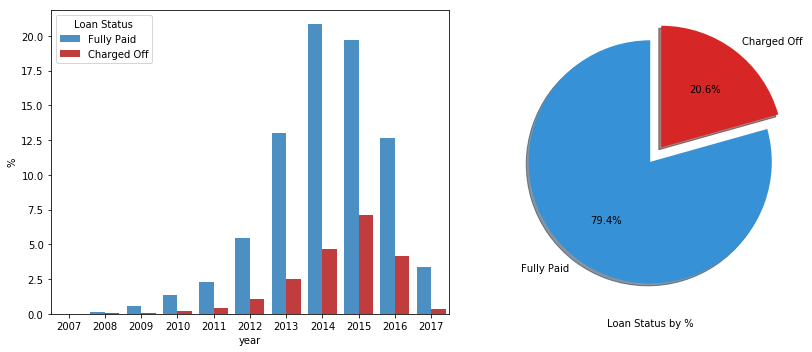

In [63]:
colors = ['#3791D7', '#D72626']
explode = (0, 0.15)
labels = ['Fully Paid', 'Charged Off']
palette = ['#3791D7', '#D72626']

fig, ax = plt.subplots(1,2, figsize=(12,5))

# bar chart
sns.barplot(x='issue_d', y='loan_amnt', hue='loan_status', data=df2, palette=palette, 
            estimator=lambda x: len(x) / len(df2) * 100, ax=ax[0])
ax[0].set_ylabel('%')
ax[0].set_xlabel('year')
ax[0].legend(title='Loan Status')

# pie chart
plt.pie(df2.loan_status.value_counts(), explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].set_xlabel('Loan Status by %')

plt.tight_layout()
plt.show()

Here we can see the break down of loans that are `Fully Paid` versus `Charged Off` from year to year and in the entire dataset.

## Loans by region
Let's break down the states into regions using the image below in order to see how loan status is effected by each region.

<img src='Five-US-Regions1-685x445.jpg'>

In [64]:
df2.addr_state.unique()

array(['VA', 'CA', 'MO', 'AZ', 'NJ', 'MN', 'WA', 'MD', 'MI', 'FL', 'NY',
       'KY', 'IN', 'CO', 'IL', 'NC', 'AL', 'CT', 'KS', 'TX', 'PA', 'UT',
       'GA', 'HI', 'NM', 'NH', 'TN', 'MA', 'OH', 'SD', 'OK', 'SC', 'OR',
       'LA', 'VT', 'DC', 'RI', 'NV', 'WV', 'WI', 'AR', 'MT', 'MS', 'WY',
       'AK', 'DE', 'IA', 'ME', 'ID', 'NE', 'ND'], dtype=object)

In [65]:
# Put states into regions
pacific = ['CA', 'OR','WA', 'NV', 'AK', 'HI', 'AZ']
frontier = ['MT', 'ID', 'CO', 'UT', 'WY', 'NM', 'TX', 'KS', 'OK']
mid_west = ['ND', 'SD', 'NE', 'WI', 'MN', 'MI', 'IA', 'IL', 'OH', 'MO', 'IN']
north_east = ['MD', 'DC', 'DE', 'NJ', 'CT', 'PA', 'NY', 'RI','MA', 'NH', 'VT', 'ME']
south = ['AR', 'LA', 'MS', 'AL', 'FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'KY', 'TN']

In [66]:
# Create region column in df2
df2['region'] = np.nan

def region(state):
    if state in pacific:
        return 'Pacific'
    elif state in frontier:
        return 'Frontier'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    elif state in south:
        return 'South'

df2['region'] = df2['addr_state'].apply(region)

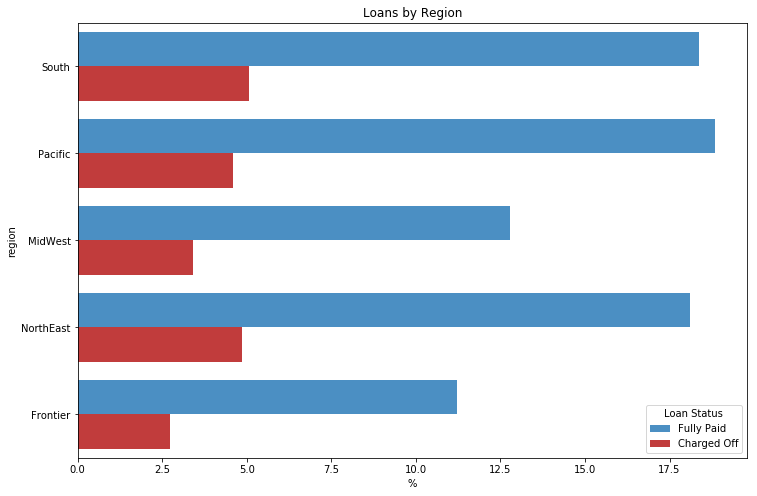

In [67]:
plt.figure(figsize=(12,8))
sns.barplot(x='loan_amnt', y='region', hue='loan_status', data=df2, palette=palette,
           estimator=lambda x: len(x) / len(df2) * 100)
plt.legend(title='Loan Status')
plt.title('Loans by Region')
plt.xlabel('%')
plt.show()

In [68]:
loans_by_region = df2.groupby(['region', 'loan_status']).size()
loans_by_region.unstack()

loan_status,Charged Off,Fully Paid
region,,
Frontier,22197,91568
MidWest,27761,104410
NorthEast,39678,147801
Pacific,37415,153800
South,41332,149806


In [69]:
# show by percentages
region_pct_df = loans_by_region.unstack().divide(loans_by_region.unstack().sum(axis=1), axis=0)
region_pct_df

loan_status,Charged Off,Fully Paid
region,,
Frontier,0.195113,0.804887
MidWest,0.210039,0.789961
NorthEast,0.211640,0.788360
Pacific,0.195670,0.804330
South,0.216242,0.783758


We can see that the majority of the loans are from the Pacific, South, and NorthEast. Note how the despite having the most loans, the Pacific region has a pretty low charge off rate compared to the other regions.

## Loans by interest rate
Now let's explore how loan status changes from year to year with regards to interest rate.

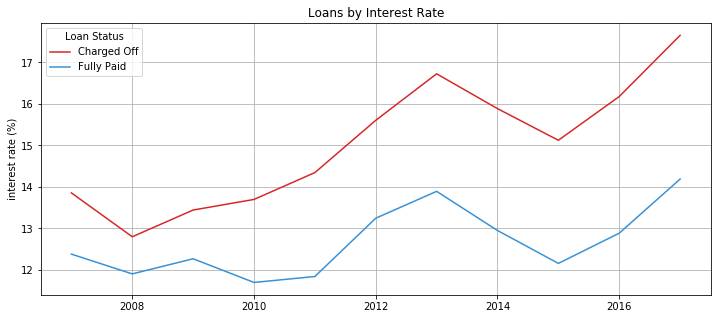

In [70]:
loans_by_interest = df2.groupby(['issue_d', 'loan_status']).int_rate.mean()

colors = ['#D72626','#3791D7']
loans_by_interest.unstack().plot(colors=colors, grid=True, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.ylabel('interest rate (%)')
plt.title('Loans by Interest Rate')
plt.show()

Interest rates seem to always be higher for loans that are charged off.  This makes sense since then there is more of a burden for the client to pay back their loan with a higher interest rate.  Interest rates for both fully paid and charged off seem to follow the same pattern except for breifly around 2010 when interest rates diverge a bit.

## Loans by FICO score

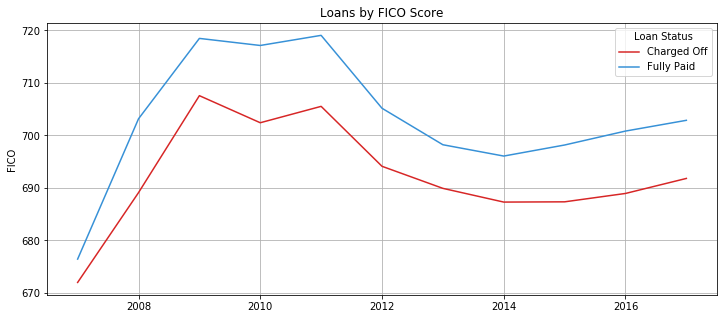

In [71]:
loans_by_fico = df2.groupby(['issue_d', 'loan_status']).fico_score.mean()

colors = ['#D72626','#3791D7']
loans_by_fico.unstack().plot(colors=colors, grid=True, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.ylabel('FICO')
plt.title('Loans by FICO Score')
plt.show()

As expected FICO scores are higher on average for fully paid loans versus charged off loans. It is interesting how since 2011 there seems to be some leniency with the FICO score.

## Loans by debt-to-income
Let's now take a look at loans with regards to dti.  Dti is the ratio of the amount of monthly debt being paid back by the loaneed with respect to their income.  

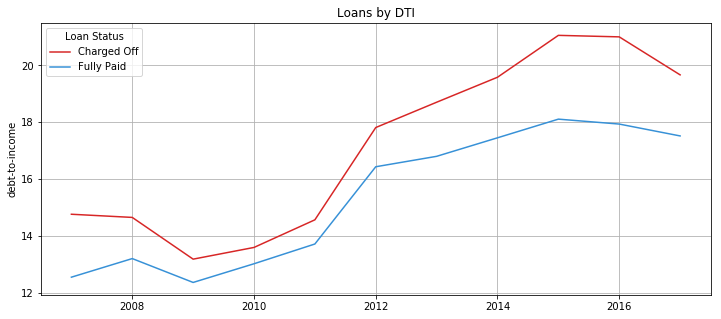

In [72]:
loans_by_dti = df2.groupby(['issue_d', 'loan_status']).dti.mean()

colors = ['#D72626','#3791D7']
loans_by_dti.unstack().plot(colors=colors, grid=True, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.ylabel('debt-to-income')
plt.title('Loans by DTI')
plt.show()

As expected dti is lower for fully paid off loans compared to charged off loans.

## Loans by annual income

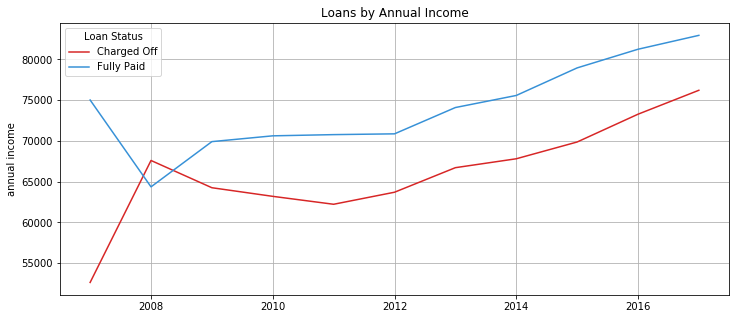

In [73]:
loans_by_income = df2.groupby(['issue_d', 'loan_status']).annual_inc.mean()

colors = ['#D72626','#3791D7']
loans_by_income.unstack().plot(colors=colors, grid=True, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.ylabel('annual income')
plt.title('Loans by Annual Income')
plt.show()

Very unexpected to see any point where average annual income is lower for charged off loans than fully paid loans.  The fact that this only happend around 2008 during the financial crisis is probably not a coincidence.

## Loans by subgrade
Now let's take a look at the loans based on their subgrade.  This [link](https://www.lendingclub.com/foliofn/rateDetail.action) explains the different grades and subgrades by interest rate. Might have to remove interest rate feature later due to collinearity issues.  

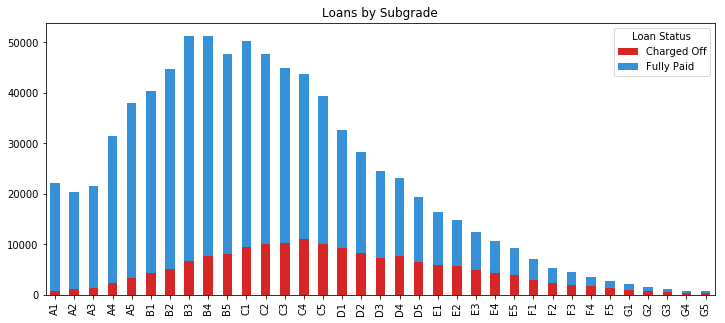

In [74]:
loans_by_subgrade = df2.groupby(['sub_grade', 'loan_status']).size()

loans_by_subgrade.unstack().plot(kind='bar', stacked=True, colors=colors, figsize=(12,5))
plt.legend(title='Loan Status')
plt.xlabel('')
plt.title('Loans by Subgrade')
plt.show()

Interesting how the loans with the most charge offs are in the C-D range, probably since LendingClub is less likely to give that many low grade (E,F,G) loans out since they are more risky.

In [75]:
loans_by_subgrade.unstack()

loan_status,Charged Off,Fully Paid
sub_grade,,
A1,754,21293
A2,1043,19334
A3,1247,20202
A4,2261,29225
A5,3396,34604
B1,4236,36185
B2,5137,39502
B3,6696,44606
B4,7624,43577


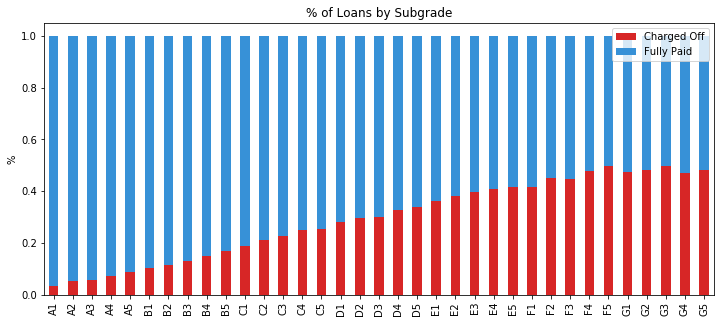

In [76]:
# show by percentages
subgrade_pct_df = loans_by_subgrade.unstack().divide(loans_by_subgrade.unstack().sum(axis=1), axis=0)
subgrade_pct_df.plot(kind='bar', stacked=True, figsize=(12,5), colors=colors)
plt.title('% of Loans by Subgrade')
plt.xlabel('')
plt.ylabel('%')
plt.legend(loc='upper right')
plt.show()

This chart shows how percentage of being charged off relative to the loan's subgrade.  Naturally lower grade loans are going to be more likely to be charged off.

## Loans by home ownership
Now let's take a look at loans based on home ownership

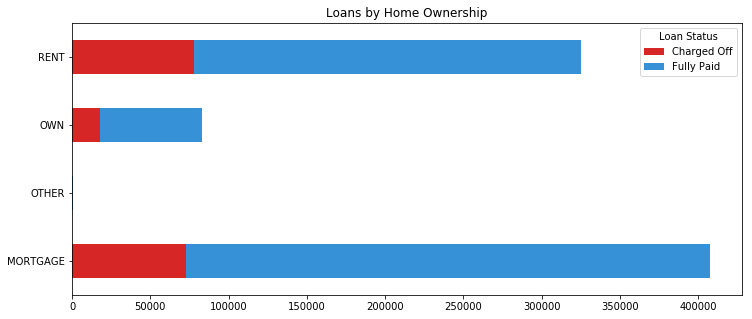

In [77]:
loans_by_homes = df2.groupby(['home_ownership', 'loan_status']).size()

loans_by_homes.unstack().plot(kind='barh', stacked=True, colors=colors, figsize=(12,5))
plt.title('Loans by Home Ownership')
plt.ylabel('')
plt.legend(title='Loan Status')
plt.show()

In [78]:
loans_by_homes.unstack()

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,72503,334829
OTHER,61,256
OWN,17861,64903
RENT,77958,247397


In [79]:
homes_pct_df = loans_by_homes.unstack().divide(loans_by_homes.unstack().sum(axis=1), axis=0)
homes_pct_df

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,0.177995,0.822005
OTHER,0.192429,0.807571
OWN,0.215806,0.784194
RENT,0.239609,0.760391


It looks like a loan is more likely to be charged off if the client is renting versus owning a home or paying a mortgage.  Not quite sure the difference between OWN and MORTGAGE though.

## Loans by purpose

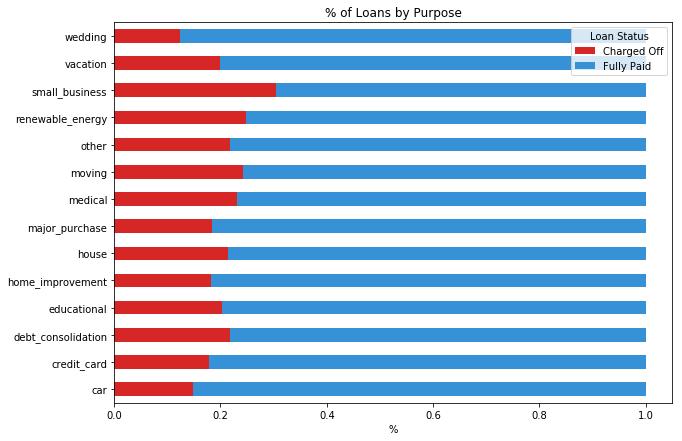

In [80]:
loans_by_purpose = df2.groupby(['purpose', 'loan_status']).size()
purpose_pct_df = loans_by_purpose.unstack().divide(loans_by_purpose.unstack().sum(axis=1), axis=0)
purpose_pct_df.plot(kind='barh', stacked=True, colors=colors, figsize=(10,7))
plt.title('% of Loans by Purpose')
plt.ylabel('')
plt.xlabel('%')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

In [81]:
purpose_pct_df

loan_status,Charged Off,Fully Paid
purpose,,
car,0.147979,0.852021
credit_card,0.178498,0.821502
debt_consolidation,0.217478,0.782522
educational,0.202186,0.797814
home_improvement,0.181786,0.818214
house,0.214996,0.785004
major_purchase,0.183251,0.816749
medical,0.230366,0.769634
moving,0.242895,0.757105


Top percentage of being charged off is under small business, moving, and renewable energy. Least likely are for weddings, cars, and credit card loans.

# Modeling

In [88]:
# Drop columns that had been log transformed and also columns that are reduntant
df_final = df2.drop(['annual_inc', 'open_acc', 'total_acc'], axis=1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 815768 entries, 0 to 1646792
Data columns (total 23 columns):
loan_amnt              815768 non-null float64
funded_amnt            815768 non-null float64
term                   815768 non-null int64
int_rate               815768 non-null float64
installment            815768 non-null float64
sub_grade              815768 non-null object
emp_length             815768 non-null float64
home_ownership         815768 non-null object
verification_status    815768 non-null object
issue_d                815768 non-null int64
loan_status            815768 non-null object
purpose                815768 non-null object
addr_state             815768 non-null object
dti                    815768 non-null float64
earliest_cr_line       815768 non-null float64
revol_bal              815768 non-null float64
revol_util             815768 non-null float64
application_type       815768 non-null object
fico_score             815768 non-null float64
annual

## Set target variable
Here we will set our target variable by changing the labels under `loan_status` to a 1 for being fully paid or a 0 for being charged off.

In [89]:
df_final.loan_status.value_counts(normalize=True)

Fully Paid     0.79359
Charged Off    0.20641
Name: loan_status, dtype: float64

In [90]:
# Turn target variable into 1's and 0's
df_final['fully_paid'] = df_final.loan_status.astype('category').cat.codes
df_final.drop('loan_status', axis=1, inplace=True)

In [91]:
df_final.fully_paid.value_counts(normalize=True)

1    0.79359
0    0.20641
Name: fully_paid, dtype: float64

## Colinearity

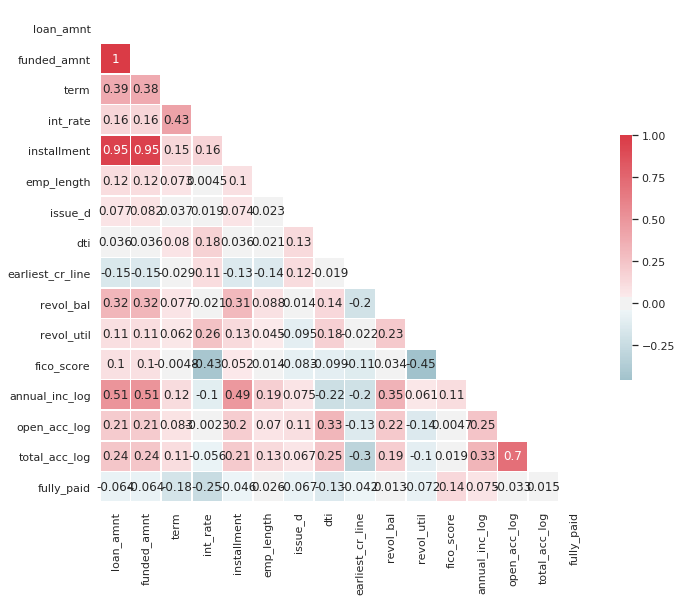

In [92]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df_final.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

After checking for collinearity, we can drop `loan_amnt`, `installment`, and `open_acc_log`

In [93]:
# drop columns with collinearity and ones that are redundant such as interest rate and address state
df_final.drop(['loan_amnt', 'installment', 'open_acc_log', 'addr_state', 'int_rate', 
               'application_type'], axis=1, inplace=True)

## Set X and y variables and get dummies

In [94]:
X = df_final.drop('fully_paid', axis=1)
y = df_final.fully_paid
X = pd.get_dummies(X, drop_first=True)

In [95]:
X.shape

(815768, 67)

## Split data and upsample and scale

In [96]:
# Use stratify in order to split train and test sets with regards to target variable ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [97]:
# Check the split of the target variable
y_train.value_counts(normalize=True)

1    0.79375
0    0.20625
Name: fully_paid, dtype: float64

In [98]:
# Use SMOTE to deal with unbalanced dataset by upsampling
# Should be done after splitting data to avoid data leakage
X_train, y_train = SMOTE(random_state=0).fit_sample(X_train, y_train) 

# checking the shape of x_resample and y_resample
print("Shape of X:", X_train.shape)
print("Shape of y:", y_train.shape)

Shape of X: (971274, 67)
Shape of y: (971274,)


In [99]:
# Check SMOTE upsampling
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int8), array([485637, 485637]))

In [100]:
# Scale the data, only fit training data to avoid data leakage
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## XGBoost
Although this is a deep learning project, it is good practice to test simpler machine learning models to compare and see if the more computationally expenseive neural network is worth building.

In [101]:
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
training_preds = clf_xgb.predict(X_train)
test_preds = clf_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test Accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 86.92%
Test Accuracy: 79.57%


In [102]:
X_train = pd.DataFrame(X_train, columns=X.columns)

In [103]:
ft_weights = pd.DataFrame(clf_xgb.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights.sort_values('weight', inplace=True)

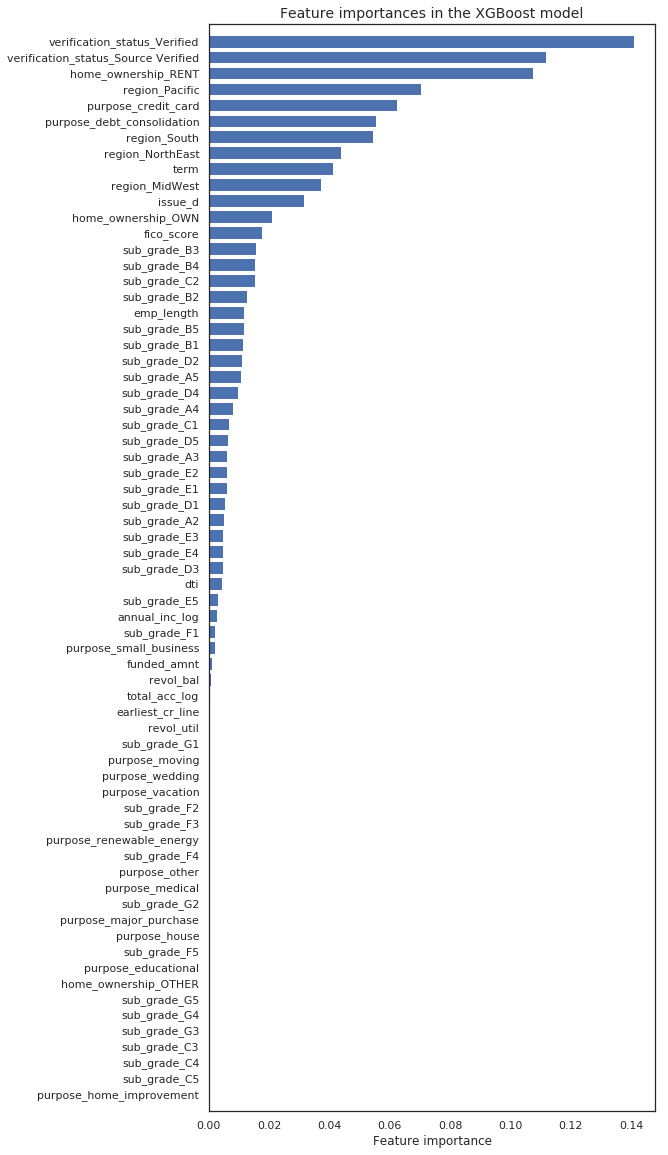

In [104]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights.index, ft_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## Baseline Model
To start we will build a simple MLP model to compare

In [105]:
# Baseline model
input_shape = X_train.shape
model = Sequential()
model.add(Dense(12, kernel_initializer='uniform', activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                816       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [107]:
model_val = model.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 971274 samples, validate on 203942 samples
Epoch 1/5
971274/971274 [==============================] - 33s 34us/step - loss: 0.4687 - acc: 0.7673 - val_loss: 0.4876 - val_acc: 0.7685
Epoch 2/5
971274/971274 [==============================] - 31s 31us/step - loss: 0.4033 - acc: 0.8030 - val_loss: 0.4893 - val_acc: 0.7843
Epoch 3/5
971274/971274 [==============================] - 30s 31us/step - loss: 0.3955 - acc: 0.8070 - val_loss: 0.4950 - val_acc: 0.7716
Epoch 4/5
971274/971274 [==============================] - 32s 32us/step - loss: 0.3929 - acc: 0.8079 - val_loss: 0.4775 - val_acc: 0.7815
Epoch 5/5
971274/971274 [==============================] - 30s 31us/step - loss: 0.3907 - acc: 0.8090 - val_loss: 0.4786 - val_acc: 0.7804


In [108]:
train_score = model.evaluate(X_train, y_train)
test_score = model.evaluate(X_test, y_test)
print('Train Score:', train_score)
print('Test Score:', test_score)

203942/203942 [==============================] - 7s 34us/step
Train Score: [0.3933107848488489, 0.8070019376610118]
Test Score: [0.4785554205390123, 0.7803542183556148]


In [109]:
model_dict = model_val.history

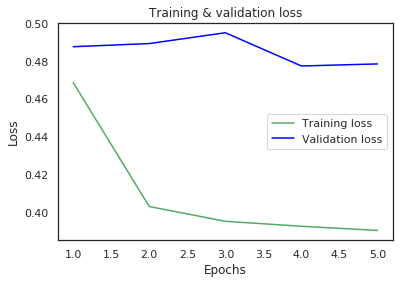

In [110]:
plt.clf()

loss_values = model_dict['loss']
val_loss_values = model_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

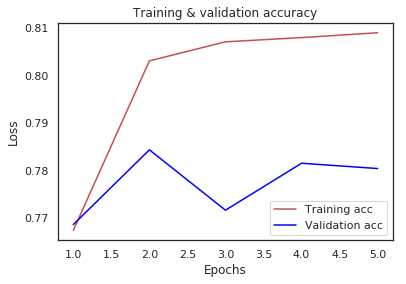

In [111]:
plt.clf()

acc_values = model_dict['acc'] 
val_acc_values = model_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some slight over fitting and it get similar accuracy to the XGBoost model.  Now let's start iterating through our MLP to see if we can improve accuracy and limit overfitting.

## Model 2 (More layers and bigger layers)

In [112]:
# More layers and bigger layers
input_shape = X_train.shape
model2 = Sequential()
model2.add(Dense(34, kernel_initializer='uniform', activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(68, kernel_initializer='uniform', activation='relu'))
model2.add(Dense(68, kernel_initializer='uniform', activation='relu'))
model2.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 34)                2312      
_________________________________________________________________
dense_5 (Dense)              (None, 68)                2380      
_________________________________________________________________
dense_6 (Dense)              (None, 68)                4692      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 69        
Total params: 9,453
Trainable params: 9,453
Non-trainable params: 0
_________________________________________________________________


In [113]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
model_val2 = model2.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/5
971274/971274 [==============================] - 35s 36us/step - loss: 0.3932 - acc: 0.8083 - val_loss: 0.4677 - val_acc: 0.7917
Epoch 2/5
971274/971274 [==============================] - 34s 35us/step - loss: 0.3587 - acc: 0.8277 - val_loss: 0.4733 - val_acc: 0.7860
Epoch 3/5
971274/971274 [==============================] - 34s 35us/step - loss: 0.3507 - acc: 0.8324 - val_loss: 0.4862 - val_acc: 0.7750
Epoch 4/5
971274/971274 [==============================] - 33s 34us/step - loss: 0.3448 - acc: 0.8364 - val_loss: 0.4649 - val_acc: 0.7918
Epoch 5/5
971274/971274 [==============================] - 34s 35us/step - loss: 0.3418 - acc: 0.8381 - val_loss: 0.4808 - val_acc: 0.7822


In [115]:
train_score2 = model2.evaluate(X_train, y_train)
test_score2 = model2.evaluate(X_test, y_test)
print('Train Score:', train_score2)
print('Test Score:', test_score2)

203942/203942 [==============================] - 7s 34us/step
Train Score: [0.33553132055947116, 0.8423524154872878]
Test Score: [0.48083572185636553, 0.782217493209438]


In [116]:
model_dict2 = model_val2.history

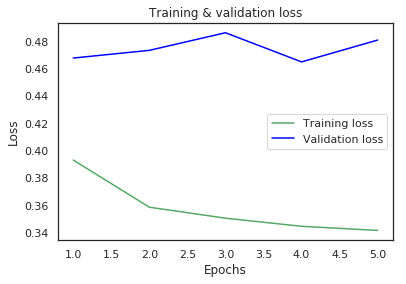

In [117]:
plt.clf()

loss_values = model_dict2['loss']
val_loss_values = model_dict2['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

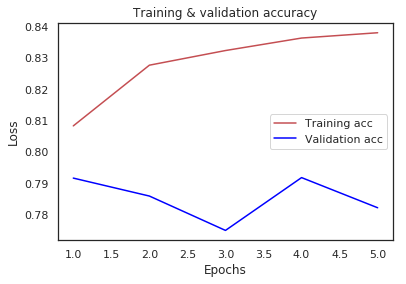

In [118]:
plt.clf()

acc_values = model_dict2['acc'] 
val_acc_values = model_dict2['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 3 (L1 regularization, more epochs)
With the deeper model there was more over fitting so let's test L1 and L2 regularization to fix this.

In [119]:
# Add L1 Regularizer and more epochs
input_shape = X_train.shape
model3 = Sequential()
model3.add(Dense(34, kernel_initializer='normal', activation='relu', input_shape=(X_train.shape[1],)))
model3.add(Dense(68, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model3.add(Dense(68, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model3.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 34)                2312      
_________________________________________________________________
dense_9 (Dense)              (None, 68)                2380      
_________________________________________________________________
dense_10 (Dense)             (None, 68)                4692      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 69        
Total params: 9,453
Trainable params: 9,453
Non-trainable params: 0
_________________________________________________________________


In [120]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [121]:
model_val3 = model3.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/10
971274/971274 [==============================] - 36s 37us/step - loss: 0.7265 - acc: 0.5030 - val_loss: 0.7049 - val_acc: 0.2069
Epoch 2/10
971274/971274 [==============================] - 34s 35us/step - loss: 0.6971 - acc: 0.5002 - val_loss: 0.6982 - val_acc: 0.2069
Epoch 3/10
971274/971274 [==============================] - 36s 37us/step - loss: 0.6971 - acc: 0.4997 - val_loss: 0.6967 - val_acc: 0.7931
Epoch 4/10
971274/971274 [==============================] - 36s 37us/step - loss: 0.6971 - acc: 0.5004 - val_loss: 0.6998 - val_acc: 0.2069
Epoch 5/10
971274/971274 [==============================] - 35s 36us/step - loss: 0.6971 - acc: 0.5006 - val_loss: 0.6924 - val_acc: 0.7931
Epoch 6/10
971274/971274 [==============================] - 36s 37us/step - loss: 0.6971 - acc: 0.4988 - val_loss: 0.6949 - val_acc: 0.7931
Epoch 7/10
971274/971274 [==============================] - 34s 35us/step - loss: 0.6971 - acc: 0.4998 - val

In [122]:
train_score3 = model3.evaluate(X_train, y_train)
test_score3 = model3.evaluate(X_test, y_test)
print('Train Score:', train_score3)
print('Test Score:', test_score3)

203942/203942 [==============================] - 8s 38us/step
Train Score: [0.6970244299486003, 0.5]
Test Score: [0.6949758079677858, 0.7931078443865451]


In [123]:
model_dict3 = model_val3.history

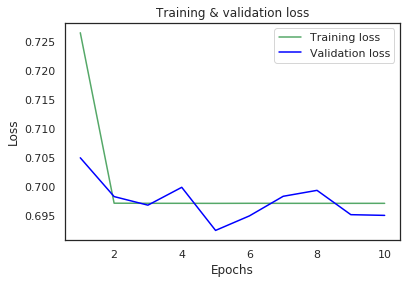

In [124]:
plt.clf()

loss_values = model_dict3['loss']
val_loss_values = model_dict3['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

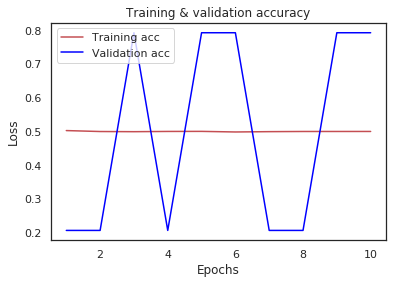

In [125]:
plt.clf()

acc_values = model_dict3['acc'] 
val_acc_values = model_dict3['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 4 (L2 regularization and more epochs)

In [126]:
# Add L2 Regularizer and more epochs
input_shape = X_train.shape
model4 = Sequential()
model4.add(Dense(34, kernel_initializer='normal', activation='relu', input_shape=(X_train.shape[1],)))
model4.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model4.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model4.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 34)                2312      
_________________________________________________________________
dense_13 (Dense)             (None, 68)                2380      
_________________________________________________________________
dense_14 (Dense)             (None, 68)                4692      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 69        
Total params: 9,453
Trainable params: 9,453
Non-trainable params: 0
_________________________________________________________________


In [127]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [128]:
model_val4 = model4.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/10
971274/971274 [==============================] - 36s 38us/step - loss: 0.4231 - acc: 0.8061 - val_loss: 0.5014 - val_acc: 0.7750
Epoch 2/10
971274/971274 [==============================] - 37s 38us/step - loss: 0.3719 - acc: 0.8297 - val_loss: 0.4820 - val_acc: 0.7888
Epoch 3/10
971274/971274 [==============================] - 36s 37us/step - loss: 0.3592 - acc: 0.8358 - val_loss: 0.4783 - val_acc: 0.7908
Epoch 4/10
971274/971274 [==============================] - 34s 35us/step - loss: 0.3513 - acc: 0.8398 - val_loss: 0.4864 - val_acc: 0.7841
Epoch 5/10
971274/971274 [==============================] - 34s 35us/step - loss: 0.3458 - acc: 0.8422 - val_loss: 0.4959 - val_acc: 0.7752
Epoch 6/10
971274/971274 [==============================] - 36s 37us/step - loss: 0.3420 - acc: 0.8438 - val_loss: 0.4696 - val_acc: 0.7937
Epoch 7/10
971274/971274 [==============================] - 34s 35us/step - loss: 0.3402 - acc: 0.8447 - val

In [129]:
train_score4 = model4.evaluate(X_train, y_train)
test_score4 = model4.evaluate(X_test, y_test)
print('Train Score:', train_score4)
print('Test Score:', test_score4)

203942/203942 [==============================] - 8s 38us/step
Train Score: [0.32999689327231174, 0.8506466764270433]
Test Score: [0.46860341871395356, 0.7944023300736522]


In [130]:
model_dict4 = model_val4.history

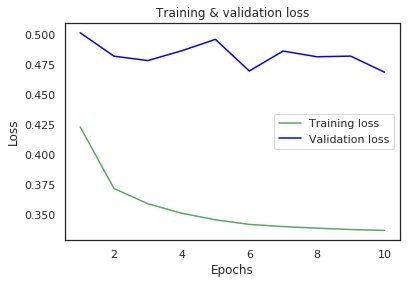

In [131]:
plt.clf()

loss_values = model_dict4['loss']
val_loss_values = model_dict4['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

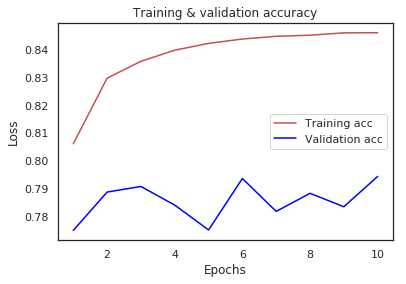

In [132]:
plt.clf()

acc_values = model_dict4['acc'] 
val_acc_values = model_dict4['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 5 (L2 regularization, dropout layers, more epochs)
Well it looks like the model with L2 regularizers workd much better, let's try using dropout layers to try and help more with overfitting.

In [133]:
# Add L2 Regularizer and more epochs and dropout layers
input_shape = X_train.shape
model5 = Sequential()
model5.add(Dense(34, kernel_initializer='normal', activation='relu', input_shape=(X_train.shape[1],)))
model5.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model5.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 34)                2312      
_________________________________________________________________
dense_17 (Dense)             (None, 68)                2380      
_________________________________________________________________
dropout_1 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 68)                4692      
_________________________________________________________________
dropout_2 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 69        
Total params: 9,453
Trainab

In [134]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
model_val5 = model5.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/10
971274/971274 [==============================] - 39s 40us/step - loss: 0.4368 - acc: 0.7993 - val_loss: 0.5133 - val_acc: 0.7648
Epoch 2/10
971274/971274 [==============================] - 37s 38us/step - loss: 0.3826 - acc: 0.8248 - val_loss: 0.4882 - val_acc: 0.7890
Epoch 3/10
971274/971274 [==============================] - 38s 39us/step - loss: 0.3723 - acc: 0.8294 - val_loss: 0.4907 - val_acc: 0.7825
Epoch 4/10
971274/971274 [==============================] - 37s 38us/step - loss: 0.3656 - acc: 0.8333 - val_loss: 0.5232 - val_acc: 0.7581
Epoch 5/10
971274/971274 [==============================] - 38s 39us/step - loss: 0.3617 - acc: 0.8355 - val_loss: 0.4889 - val_acc: 0.7828
Epoch 6/10
971274/971274 [==============================] - 37s 38us/step - loss: 0.3590 - acc: 0.8374 - val_loss: 0.4820 - val_acc: 0.7879
Epoch 7/10
971274/971274 [==============================] - 39s 40us/step - loss: 0.3561 - acc: 0.8388 - val

In [136]:
train_score5 = model5.evaluate(X_train, y_train)
test_score5 = model5.evaluate(X_test, y_test)
print('Train Score:', train_score5)
print('Test Score:', test_score5)

203942/203942 [==============================] - 9s 42us/step
Train Score: [0.3399372565855004, 0.8474910272487475]
Test Score: [0.47588755540985445, 0.7943042629761442]


In [137]:
model_dict5 = model_val5.history

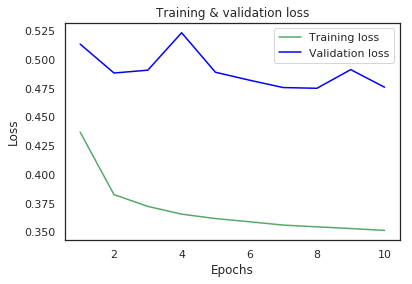

In [138]:
plt.clf()

loss_values = model_dict5['loss']
val_loss_values = model_dict5['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

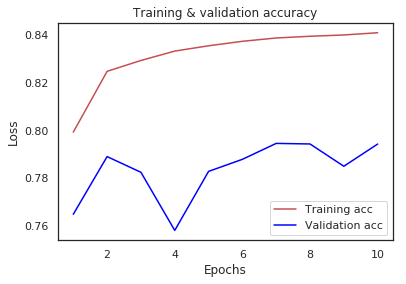

In [139]:
plt.clf()

acc_values = model_dict5['acc'] 
val_acc_values = model_dict5['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Final Model (Much more epochs)
With the above model looking like validation accuracy could possibly keep increasing, we will now train this model for longer to see if that increases accuracy.

In [140]:
# Final model with L2 and dropout layers and more epochs
input_shape = X_train.shape
model6 = Sequential()
model6.add(Dense(34, kernel_initializer='normal', activation='relu', input_shape=(X_train.shape[1],)))
model6.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(68, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model6.add(Dropout(0.3))
model6.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 34)                2312      
_________________________________________________________________
dense_21 (Dense)             (None, 68)                2380      
_________________________________________________________________
dropout_3 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 68)                4692      
_________________________________________________________________
dropout_4 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 69        
Total params: 9,453
Trainable params: 9,453
Non-trainable params: 0
_________________________________________________________________


In [141]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [142]:
model_val6 = model6.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test))

Train on 971274 samples, validate on 203942 samples
Epoch 1/100
971274/971274 [==============================] - 16s 17us/step - loss: 0.4578 - acc: 0.7933 - val_loss: 0.5198 - val_acc: 0.7642
Epoch 2/100
971274/971274 [==============================] - 15s 16us/step - loss: 0.3832 - acc: 0.8288 - val_loss: 0.5030 - val_acc: 0.7830
Epoch 3/100
971274/971274 [==============================] - 15s 16us/step - loss: 0.3702 - acc: 0.8334 - val_loss: 0.4802 - val_acc: 0.7934
Epoch 4/100
971274/971274 [==============================] - 15s 16us/step - loss: 0.3630 - acc: 0.8362 - val_loss: 0.4855 - val_acc: 0.7889
Epoch 5/100
971274/971274 [==============================] - 15s 16us/step - loss: 0.3587 - acc: 0.8382 - val_loss: 0.4931 - val_acc: 0.7799
Epoch 6/100
971274/971274 [==============================] - 16s 17us/step - loss: 0.3561 - acc: 0.8390 - val_loss: 0.4857 - val_acc: 0.7876
Epoch 7/100
971274/971274 [==============================] - 15s 16us/step - loss: 0.3533 - acc: 0.840

In [143]:
train_score6 = model6.evaluate(X_train, y_train)
test_score6 = model6.evaluate(X_test, y_test)
print('Train Score:', train_score6)
print('Test Score:', test_score6)

203942/203942 [==============================] - 8s 40us/step
Train Score: [0.320989684906385, 0.856310371738562]
Test Score: [0.4697240951043807, 0.7940394818128722]


In [144]:
model_dict6 = model_val6.history

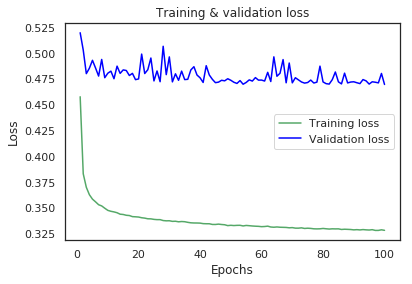

In [145]:
plt.clf()

loss_values = model_dict6['loss']
val_loss_values = model_dict6['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

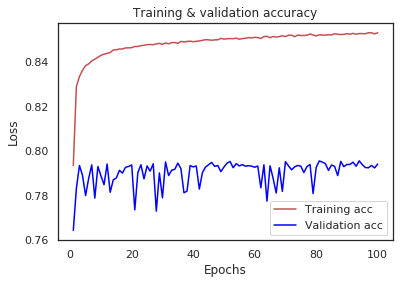

In [146]:
plt.clf()

acc_values = model_dict6['acc'] 
val_acc_values = model_dict6['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Conclusion
Well a bit disappointing, although accuracy ended up being around 79%, it seems that the model would be better off using early stopping and just using 5 or so epochs.  Also note that the MLP could never get significant accuracy scores better than the XGBoost model so maybe in a real use case, deep learning wouldn't be necessary for this type of problem.

# Future Work
- Gather more data
- Further explore features for different feature selections
- Test different initializers and optimizers
- Experiment with more feature engineering